# Train Test Label Drift

This notebooks provides an overview for using and understanding feature drift check.

**Structure:**

- [What is a label drift?](#what_is_label_drift)
- [Run check on a Classification task](#run_check_on_classification)
- [Run check on an Object Detection task](#run_check_on_object_detection)

## What is a label drift? <a name='what_is_label_drift'></a>

Data drift is simply a change in the distribution of data over time. It is also one of the top reasons of a machine learning model performance degrades over time.
Specifically, label drift (or concept drift) indicates changes in the label we are trying to predict.

Causes of concept drift include:

- Natural drift in the data, such as lighting (brightness) changes between summer and winter.
- Labeling issues, such as an analyst drawing incorrect bounding boxes for an object detection task.

In the context of machine learning, drift between the training set and the test set will likely make the model to be prone to errors. In other words, this means that the model was trained on data that is different from the current test data, thus it will probably make more mistakes predicting the target variable.

### How deepchecks detects label drift

There are many methods to detect label drift, that usually include statistical methods that aim to measure difference between distribution of 2 given label sets. We exprimented with various approaches and found that for detecting drift between 2 one-dimensional distribution, the following 2 methods give the best results:

- <a href="https://www.lexjansen.com/wuss/2017/47_Final_Paper_PDF.pdf" target="_blank">Population Stability Index (PSI)</a>
- <a href="https://en.wikipedia.org/wiki/Wasserstein_metric" target="_blank">Wasserstein metric (Earth Movers Distance)</a>

For numerical features, the check uses the Earth Movers Distance method and for the categorical features it uses the PSI.
The check calculates drift between train dataset and test dataset per feature, using these 2 statistical measures.


## Different measurement on label

In computer vision specifically, our labels may be complex, and measuring their drift is not a straightforward task. Therefore, we calculate drift on different measures on labels. 
For now, in deepchecks, we support these measurements (on which we calculate drift):

- For both classification and object detection tasks, we calculate drift in the distribution of classes.
- For object detection tasks, we also calculate drift in the distribution of bounding box areas and distribution of number of bounding boxes per image.

## Run the check on a Classification task (MNIST) <a name='run_check_on_classification'></a>

### Imports

In [1]:
from deepchecks.vision.dataset import VisionData
from deepchecks.vision.checks import SimpleFeatureContributionTrainTest

### Loading data:

In [2]:
from deepchecks.vision.datasets.classification.mnist import load_dataset

train_ds = load_dataset(train=True, object_type='VisionData')
test_ds = load_dataset(train=False, object_type='VisionData')

In [3]:
from deepchecks.vision.datasets.classification.mnist import load_dataset

mnist_dataloader_train = load_dataset(train=True)
mnist_dataloader_test = load_dataset(train=False)

In [4]:
from deepchecks.vision.utils.transformations import un_normalize_batch

def mnist_image_formatter(batch):
    """Create function which inverse the data normalization."""
    tensor = batch[0]
    tensor = tensor.permute(0, 2, 3, 1)
    return un_normalize_batch(tensor, (0.1307,), (0.3081,))

In [5]:
from deepchecks.vision.utils.classification_formatters import ClassificationLabelFormatter
from deepchecks.vision.utils.image_formatters import ImageFormatter

train_ds = VisionData(mnist_dataloader_train, image_formatter=ImageFormatter(mnist_image_formatter), label_formatter=ClassificationLabelFormatter())
test_ds = VisionData(mnist_dataloader_test, image_formatter=ImageFormatter(mnist_image_formatter), label_formatter=ClassificationLabelFormatter())

## Running SimpleFeatureContributionTrainTest on classification

In [6]:
check = SimpleFeatureContributionTrainTest()
check.run(train_ds, test_ds)

Single Feature Contribution Train-Test Return the Predictive Power Score of all features, in order to estimate each feature's ability to predict the label. Read More... Additional Outputs ✓ Nothing found

### Insert bias:

In [53]:
# Create bias in the image_formatter that will 
def mnist_image_formatter_with_bias(batch):
    """Create function which inverse the data normalization."""
    tensor = batch[0]
    tensor = tensor.permute(0, 2, 3, 1)
    ret = un_normalize_batch(tensor, (0.1307,), (0.3081,))
    for i, label in enumerate(batch[1]):
        ret[i] = ret[i].clip(min=5 * label, max = 180 + 5 * label)
    return ret

In [54]:
# train_ds = VisionData(mnist_dataloader_train, image_formatter=ImageFormatter(mnist_image_formatter), label_formatter=ClassificationLabelFormatter(lambda arr: [0 if x!=9 else 1 for x in arr[1]]))
# test_ds = VisionData(mnist_dataloader_test, image_formatter=ImageFormatter(mnist_image_formatter_with_bias), label_formatter=ClassificationLabelFormatter(lambda arr: [0 if x!=9 else 1 for x in arr[1]]))

In [55]:
train_ds = VisionData(mnist_dataloader_train, image_formatter=ImageFormatter(mnist_image_formatter),
                   label_formatter=ClassificationLabelFormatter(lambda arr: [int(x) for x in arr[1]]))
test_ds = VisionData(mnist_dataloader_test, image_formatter=ImageFormatter(mnist_image_formatter_with_bias),
                  label_formatter=ClassificationLabelFormatter(lambda arr: [int(x) for x in arr[1]]))

### Re-run after bias

Single Feature Contribution Train-Test Return the Predictive Power Score of all features, in order to estimate each feature's ability to predict the label. Read More... Additional Outputs

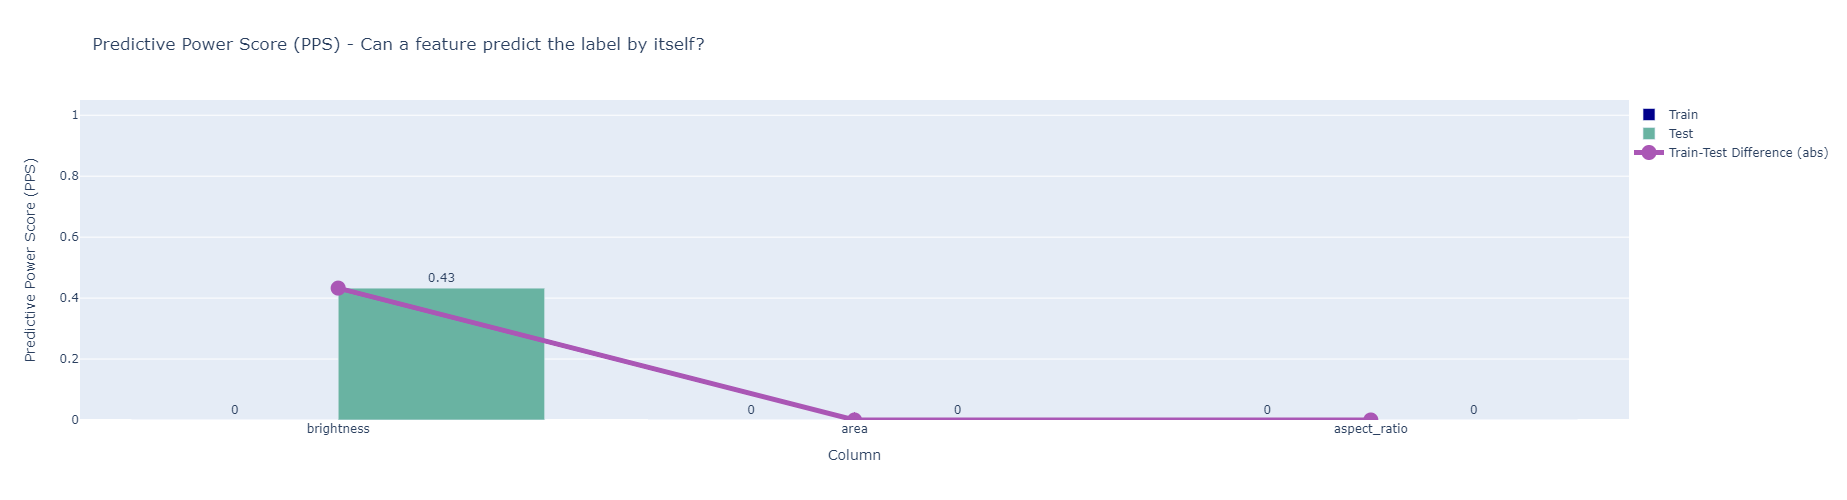

The Predictive Power Score (PPS) is used to estimate the ability of a feature to predict the label by itself. (Read more about Predictive Power Score ) In the graph above , we should suspect we have problems in our data if: 1. Train dataset PPS values are high : Can indicate that this feature's success in predicting the label is actually due to data leakage, meaning that the feature holds information that is based on the label to begin with. 2. Large difference between train and test PPS (train PPS is larger): An even more powerful indication of data leakage, as a feature that was powerful in train but not in test can be explained by leakage in train that is not relevant to a new dataset. 3. Large difference between test and train PPS (test PPS is larger): An anomalous value, could indicate drift in test dataset that caused a coincidental correlation to the target label.

In [56]:
check = SimpleFeatureContributionTrainTest()
check.run(train_ds, test_ds)

## Run the check on an Object Detection task (COCO) <a name='run_check_on_object_detection'></a>

In [ ]:
from deepchecks.vision.datasets.detection.coco import load_dataset, yolo_label_formatter

train_dataloader = load_dataset(train=True)
test_dataloader = load_dataset(train=False)

In [ ]:
from deepchecks.vision.utils.detection_formatters import DetectionLabelFormatter

train_ds = VisionData(train_dataloader, label_formatter=DetectionLabelFormatter(yolo_label_formatter))
test_ds = VisionData(test_dataloader, label_formatter=DetectionLabelFormatter(yolo_label_formatter))

In [ ]:
check = SimpleFeatureContributionTrainTest()
check.run(train_ds, test_ds)